In [1]:
import torch
from torch import nn
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [2]:
# Input data structure
# 0: Concentration at time T
# 1: xwind at time T
# 2: xwind ant time T+6
# 3: ywind at time T
# 4: ywin at time T+6
# 5: abl height at time T
# 6: abl height at time T+6
# 7: surface air pressure at time T
# 8: surface air pressure at time T+6

In [3]:
class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()
        
        self.input_channels = 8
        self.output_channels = 1

        # Pooling function
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Encoder (Contracting Path)
        self.enc1 = self._double_conv(self.input_channels, 64) 
        self.enc2 = self._double_conv(64, 128) 
        self.enc3 = self._double_conv(128, 256) 
        self.enc4 = self._double_conv(256, 512)  
        
        # Decoder (Expansive Path)
        self.up4 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # 
        self.dec4 = self._double_conv(512, 256) 

        self.up3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # 
        self.dec3 = self._double_conv(256, 128)  # 128*2 because of skip connection
        
        self.up2 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) 
        self.dec2 = self._double_conv(128, 64)  # 64*2 because of skip connection
        
        # Final layer
        self.final = nn.Sequential(
            nn.Conv2d(64, self.output_channels, kernel_size=1),
        )
        
    def _double_conv(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels), # should use this
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding='same'),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        
    def forward(self, x):
        # Calls the various steps defined in init

        # Encoder
        enc1 = self.enc1(x)
        enc1_pool = self.pool(enc1)
        
        enc2 = self.enc2(enc1_pool)
        enc2_pool = self.pool(enc2)
        
        enc3 = self.enc3(enc2_pool)
        enc3_pool = self.pool(enc3)

        enc4 = self.enc4(enc3_pool) # Don't apply pool to final encoding step
    
        # Decoder with skip connections
        up4 = self.up4(enc4) 
        up4 = torch.cat((up4, enc3), dim=1)  # Skip connection
        dec4 = self.dec4(up4) 

        up3 = self.up3(dec4)
        up3 = torch.cat((up3, enc2), dim=1)  # Skip connection
        dec3 = self.dec3(up3)
        
        up2 = self.up2(dec3)
        up2 = torch.cat((up2, enc1), dim=1)  # Skip connection
        dec2 = self.dec2(up2)
        
        # Final output
        output = self.final(dec2)
        
        return output 
    
# Custom loss function
def physical_loss(pred, target):
    mse = F.mse_loss(pred, target)
    input_mass = target.sum()  # Mass of current timestep (input)
    pred_mass = pred.sum()
    mass_loss = F.mse_loss(pred_mass, input_mass)
    return mse #+ mass_loss*1e-10

In [4]:
def train(data_path, model_path):

    data = np.load(data_path)

    # Convert to PyTorch tensors
    X_tensor = torch.FloatTensor(data['pred_vars'][:, 1:, :, :])
    y_tensor = torch.FloatTensor(data['target_vars'][:, np.newaxis, :, :]) # Add channel dimension

    # First split: 80% train, 20% temp (val + test)
    X_train, X_temp, y_train, y_temp = train_test_split(
        X_tensor, y_tensor, test_size=0.2, random_state=42
    )

    # Second split: 50% val, 50% test (10% each of full dataset)
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, random_state=42
    )

    # Convert test tensors to numpy arrays
    X_test_np = X_test.numpy()
    y_test_np = y_test.numpy()

    # Save test set as .npz file
    np.savez(
        'test_set.npz',  # Filename
        X_test=X_test_np,  # Save predictors
        y_test=y_test_np   # Save targets
    )

    print("Test set saved as 'test_set.npz'")
    print(f"Training set: {X_train.shape}, {y_train.shape}")
    print(f"Validation set: {X_val.shape}, {y_val.shape}")
    print(f"Test set: {X_test.shape}, {y_test.shape}")

    # Set up DataLoaders with batch size and workers
    batch_size = 6  # Adjust based on GPU memory
    train_loader = DataLoader(TensorDataset(X_train, y_train), 
                             batch_size=batch_size, 
                             shuffle=True)  
    val_loader = DataLoader(TensorDataset(X_val, y_val), 
                           batch_size=batch_size, 
                             shuffle=True)

    # Initialize model, loss, optimizer
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = UNET().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)

    # Training loop 
    num_epochs = 125
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = physical_loss(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                val_loss += physical_loss(outputs, targets).item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        scheduler.step(avg_val_loss)

        if epoch % 5 == 0:
            with torch.no_grad():
                inputs, targets = next(iter(val_loader))
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                
                pred_img = outputs[0, 0].cpu().numpy()
                target_img = targets[0, 0].cpu().numpy()
                
                fig, axs = plt.subplots(1, 2, figsize=(12, 4))
                
                # Plot prediction with colorbar
                im1 = axs[0].imshow(pred_img, cmap='viridis')
                axs[0].set_title("Prediction")
                fig.colorbar(im1, ax=axs[0], fraction=0.046, pad=0.04)
                
                # Plot target with colorbar
                im2 = axs[1].imshow(target_img, cmap='viridis', vmin=0, vmax=20)
                axs[1].set_title("Target")
                fig.colorbar(im2, ax=axs[1], fraction=0.046, pad=0.04)
                
                plt.tight_layout()
                plt.show()
                print(f'Epoch {epoch+1}/{num_epochs}')
                print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

    # Save the model
    torch.save(model.state_dict(), model_path)

Test set saved as 'test_set.npz'
Training set: torch.Size([873, 8, 336, 336]), torch.Size([873, 1, 336, 336])
Validation set: torch.Size([109, 8, 336, 336]), torch.Size([109, 1, 336, 336])
Test set: torch.Size([110, 8, 336, 336]), torch.Size([110, 1, 336, 336])


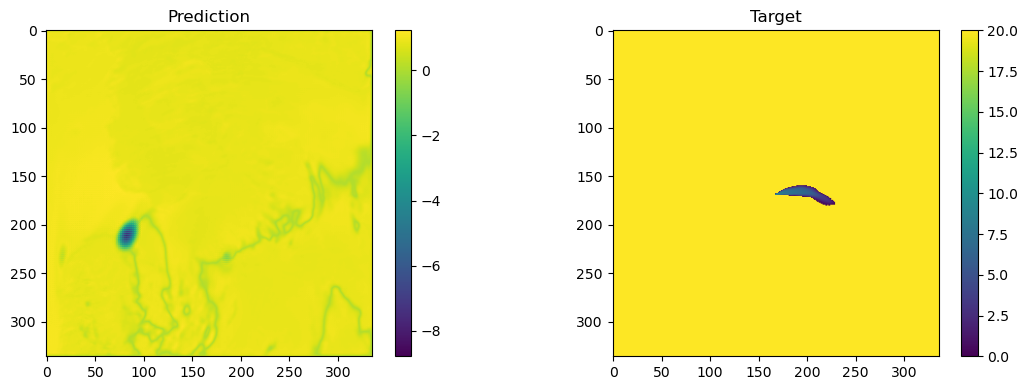

Epoch 1/125
Train Loss: 373.6141, Val Loss: 366.6705


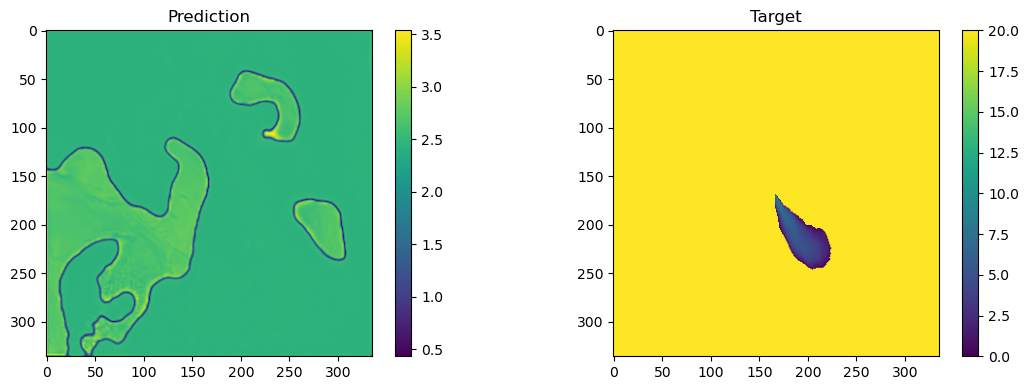

Epoch 6/125
Train Loss: 308.6186, Val Loss: 302.1572


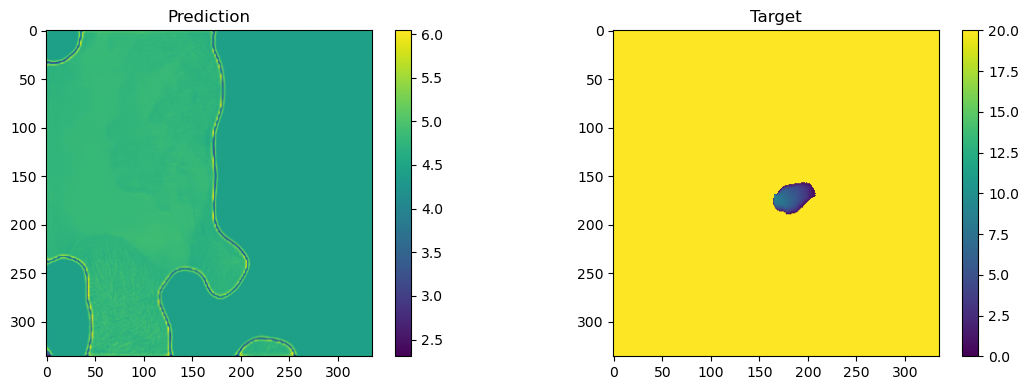

Epoch 11/125
Train Loss: 240.2889, Val Loss: 234.9121


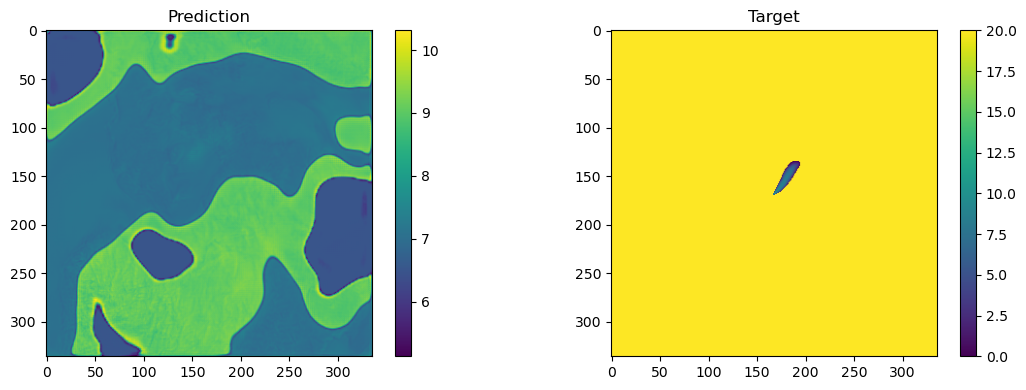

Epoch 16/125
Train Loss: 172.6353, Val Loss: 161.2541


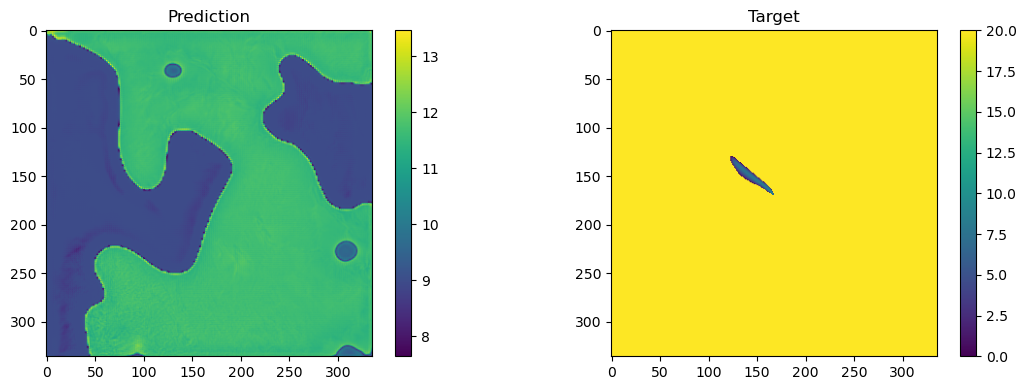

Epoch 21/125
Train Loss: 110.5921, Val Loss: 102.2384


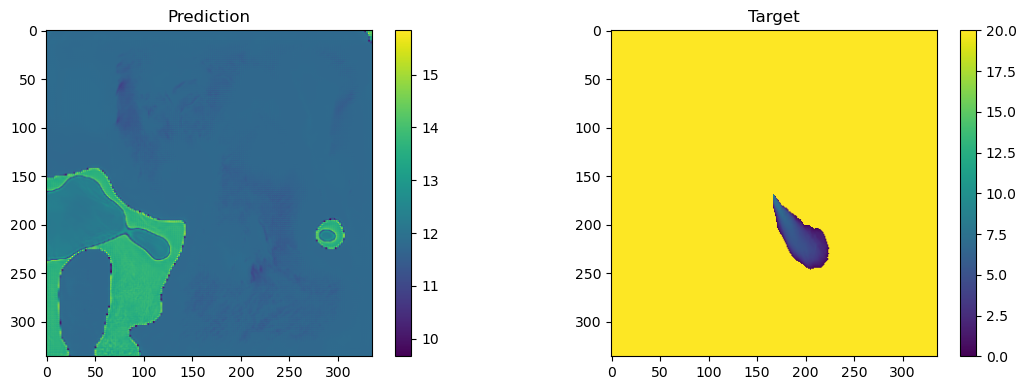

Epoch 26/125
Train Loss: 60.8511, Val Loss: 59.0266


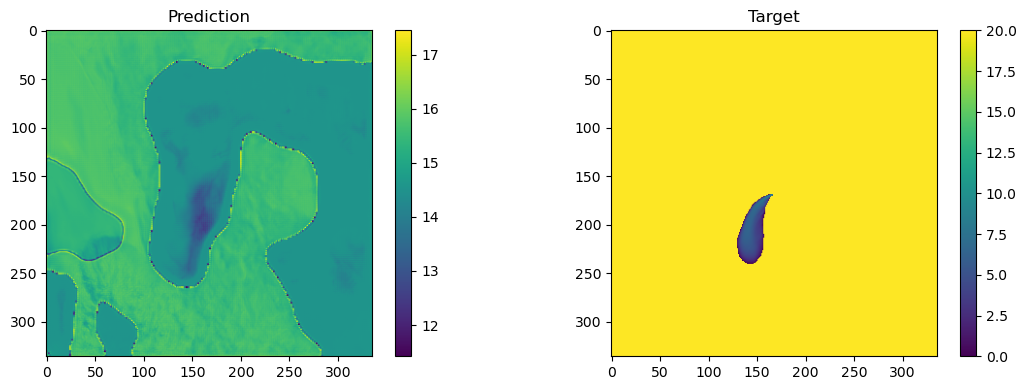

Epoch 31/125
Train Loss: 28.0616, Val Loss: 25.3680


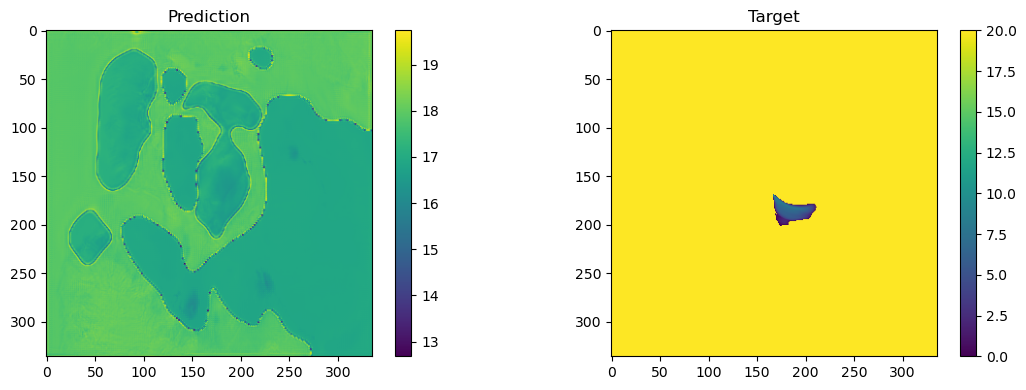

Epoch 36/125
Train Loss: 10.6818, Val Loss: 9.5668


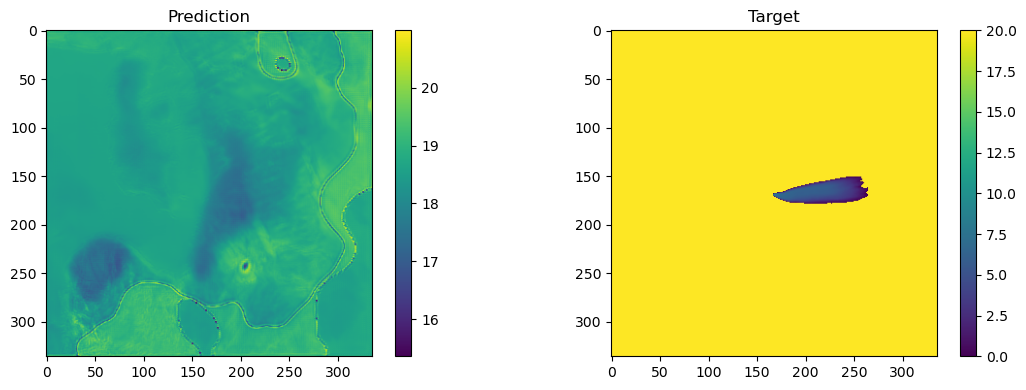

Epoch 41/125
Train Loss: 4.3036, Val Loss: 4.1516


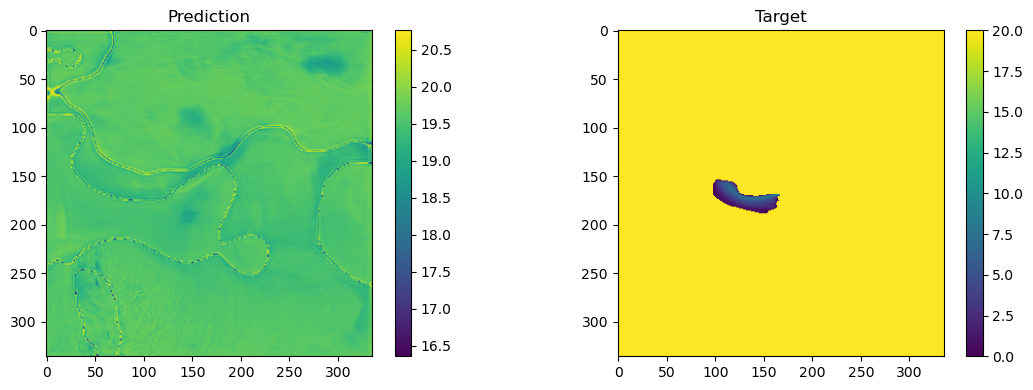

Epoch 46/125
Train Loss: 2.9137, Val Loss: 2.9170


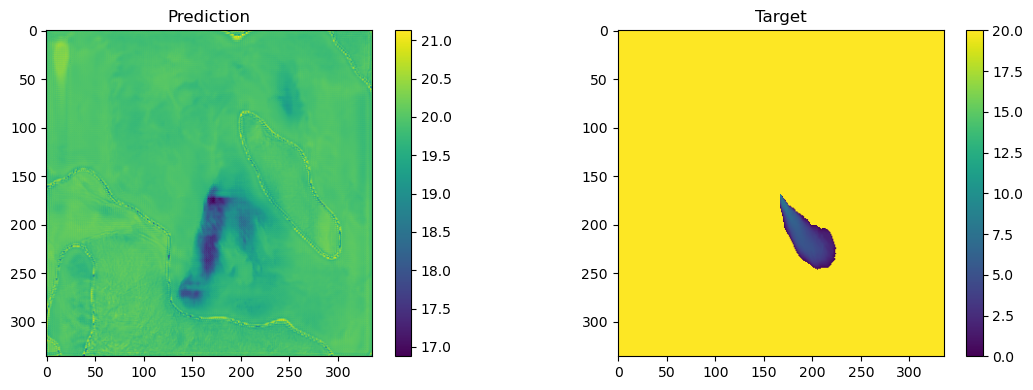

Epoch 51/125
Train Loss: 2.6434, Val Loss: 2.6895


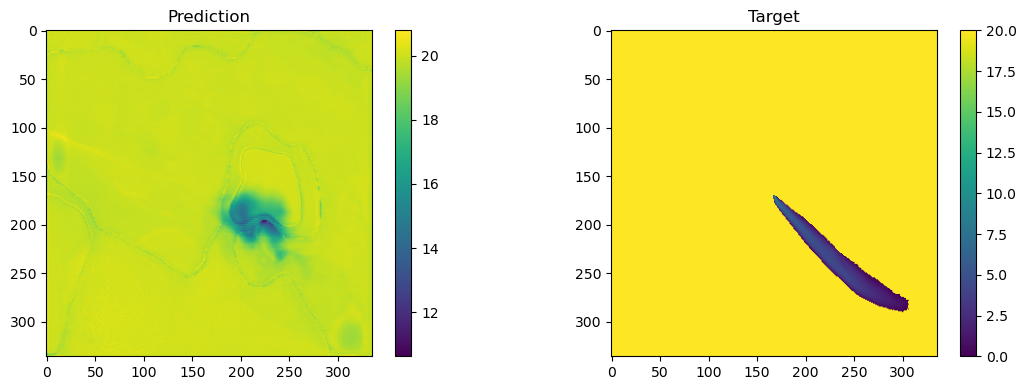

Epoch 56/125
Train Loss: 2.4763, Val Loss: 2.5366


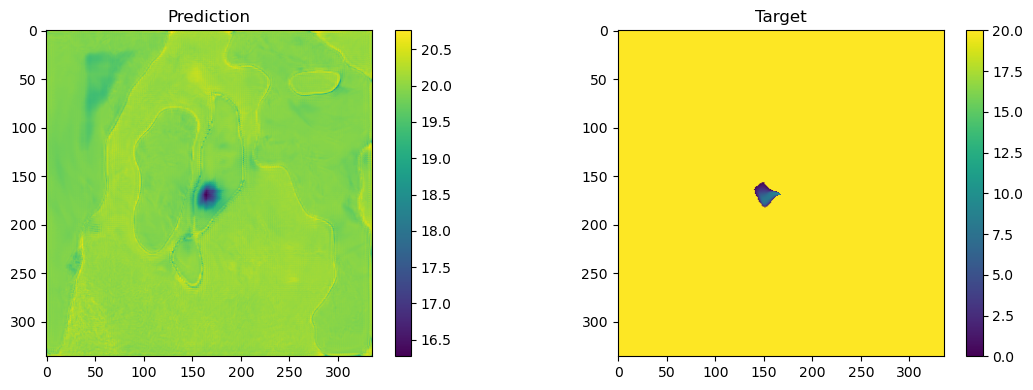

Epoch 61/125
Train Loss: 2.3898, Val Loss: 2.3055


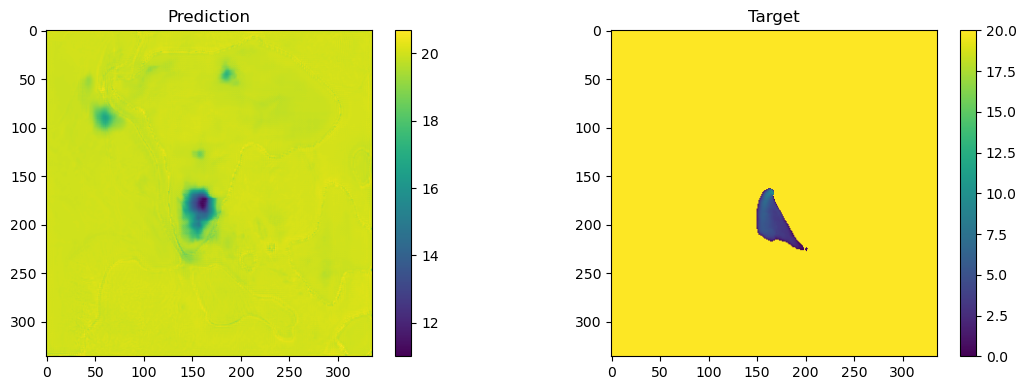

Epoch 66/125
Train Loss: 2.1316, Val Loss: 2.2654


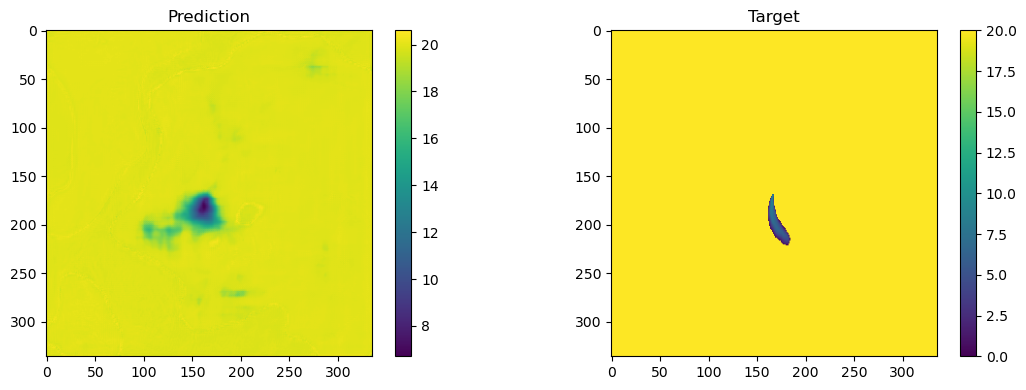

Epoch 71/125
Train Loss: 1.9785, Val Loss: 2.2871


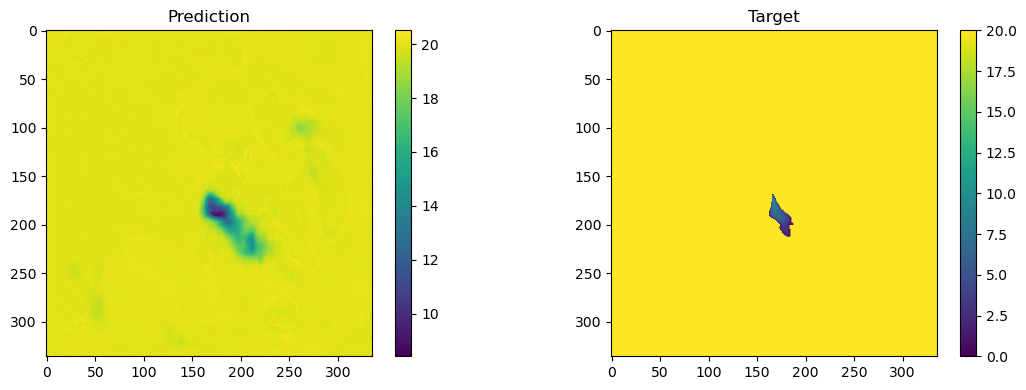

Epoch 76/125
Train Loss: 1.8926, Val Loss: 2.1872


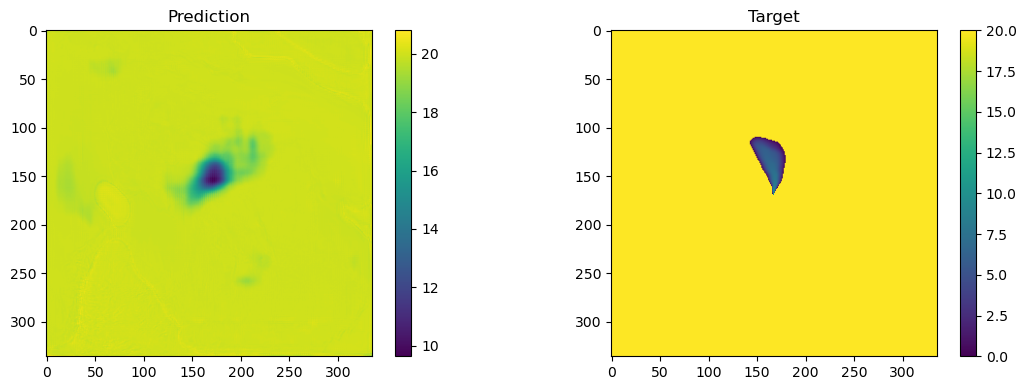

Epoch 81/125
Train Loss: 1.8644, Val Loss: 2.2476


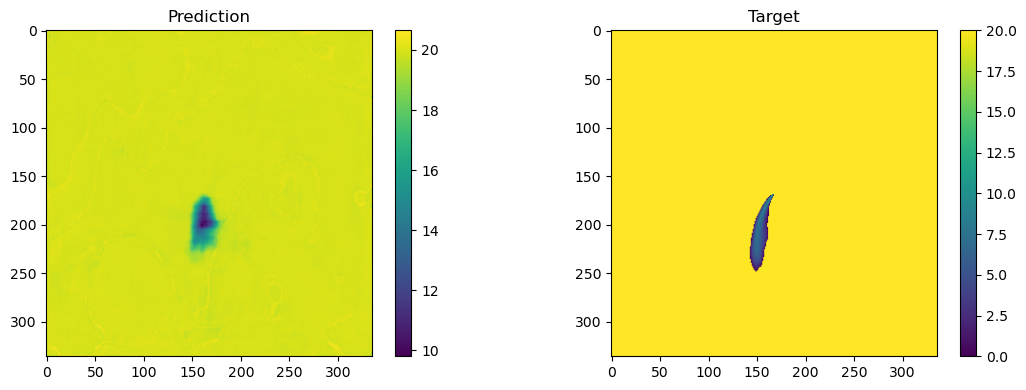

Epoch 86/125
Train Loss: 1.8257, Val Loss: 2.2668


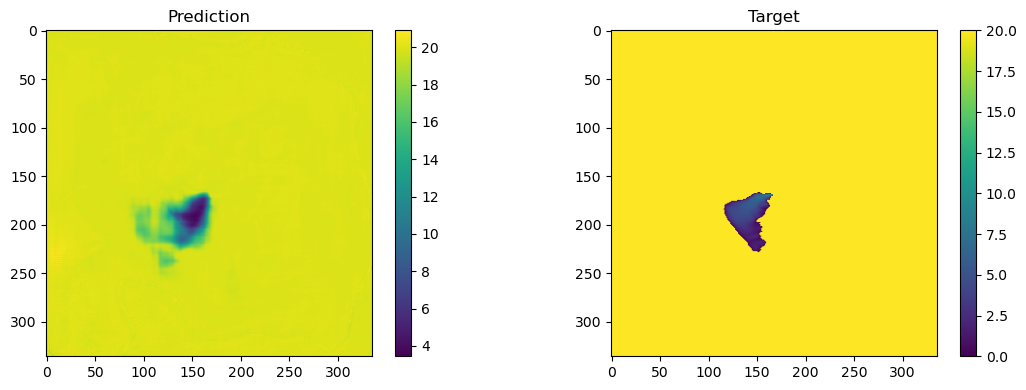

Epoch 91/125
Train Loss: 1.8138, Val Loss: 2.1999


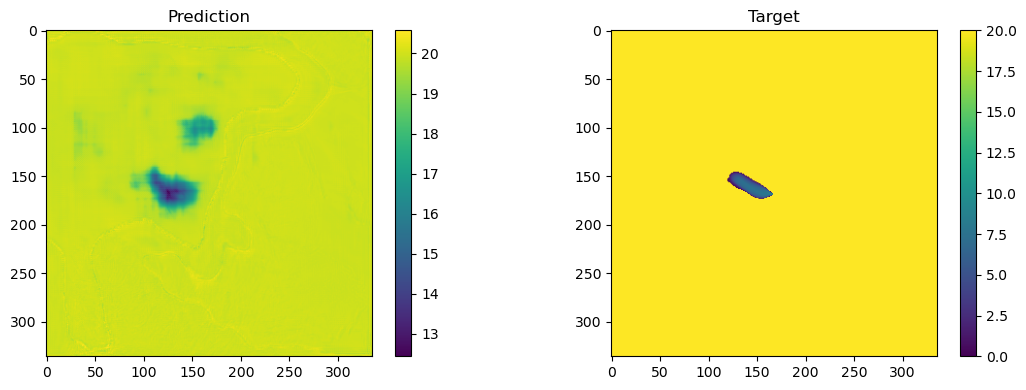

Epoch 96/125
Train Loss: 1.7931, Val Loss: 2.1952


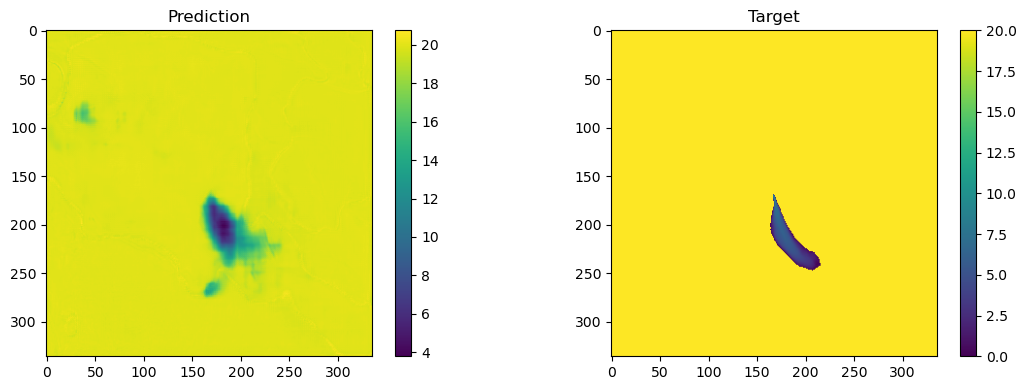

Epoch 101/125
Train Loss: 1.7997, Val Loss: 2.2122


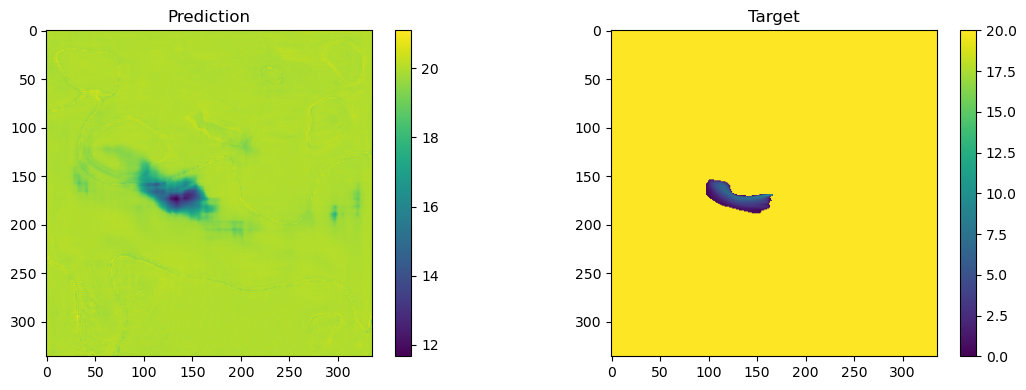

Epoch 106/125
Train Loss: 1.7984, Val Loss: 2.4500


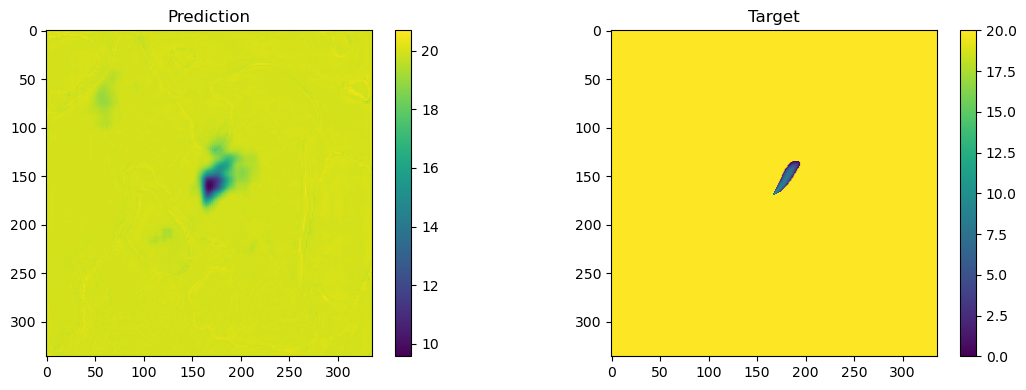

Epoch 111/125
Train Loss: 1.8188, Val Loss: 2.2250


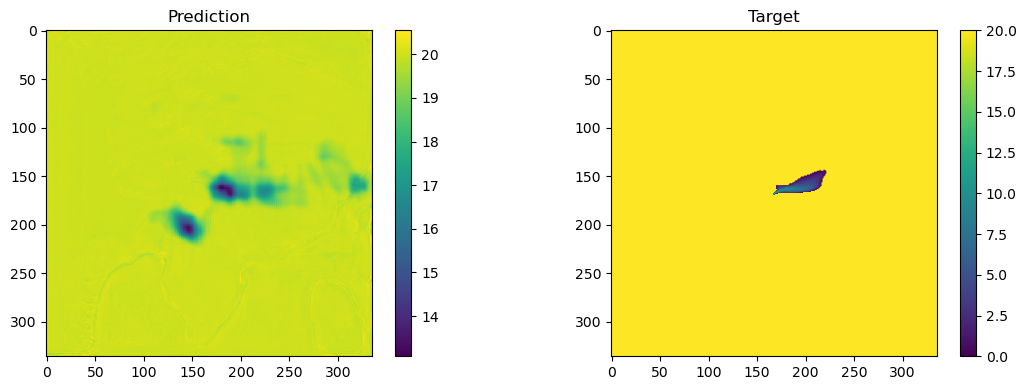

Epoch 116/125
Train Loss: 1.7983, Val Loss: 2.2038


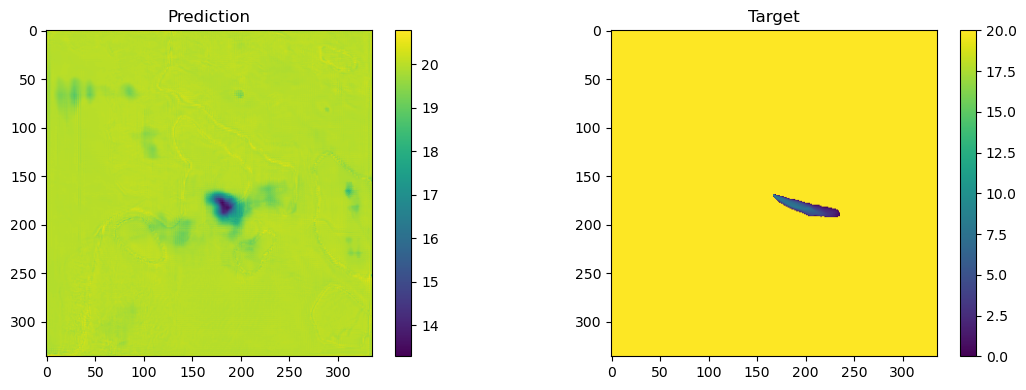

Epoch 121/125
Train Loss: 1.7894, Val Loss: 2.2052
Epoch 125/125
Train Loss: 1.8005, Val Loss: 2.2011


In [5]:
x_data_path = 'scaled_combined_t6_data_accumulated.npz'

combined_file = train(x_data_path, 'models/unet_accumulated_125_lr0001.pth')